In [1]:
pip install mtcnn

Note: you may need to restart the kernel to use updated packages.


In [2]:
from random import shuffle, choice
from PIL import Image
from random import randint
from matplotlib.pyplot import figure
import os
import numpy as np
import matplotlib as plt
import random
import glob
import matplotlib.pyplot as plt
import time
import pandas as pd
import cv2
import math

from os import listdir
from os.path import isdir
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from numpy import load
from numpy import expand_dims
from mtcnn.mtcnn import MTCNN

from pathlib import Path
from tqdm import tqdm

import tensorflow as tf
import re
import csv

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report



def load_rgb_data(IMAGE_DIRECTORY,IMAGE_SIZE, shuffle=True):
    print("Loading images...")
    data = []
    #labels=[]
    directories = next(os.walk(IMAGE_DIRECTORY))[1]
    print(directories)
    for diretcory_name in directories:
        print("Loading {0}".format(diretcory_name))
        file_names = next(os.walk(os.path.join(IMAGE_DIRECTORY, diretcory_name)))[2]
        print("we will load [", len(file_names), "] files from [",diretcory_name,"] class ..." )
        for i in range(len(file_names)):
            
            image_name = file_names[i]
            image_path = os.path.join(IMAGE_DIRECTORY, diretcory_name, image_name)
            if ('.DS_Store' not in image_path):
                #print(image_path)
                label = diretcory_name
                img = Image.open(image_path)
                rgbimg = Image.new("RGB", img.size)
                rgbimg.paste(img)
                img=rgbimg
            
                #print(np.array(img).shape)
                img = img.resize((IMAGE_SIZE, IMAGE_SIZE), Image.ANTIALIAS)
                #print(np.array(img).shape)
                data.append([np.array(img), label])

    if (shuffle):
        random.shuffle(data)
    training_images = np.array([i[0] for i in data]).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
    training_labels = np.array([i[1] for i in data])
    
    print("File loading completed.")

    return training_images, training_labels

def display_image(trainX, trainY, index=0):
    plt.imshow(trainX[index])
    print ("Label = " + str(np.squeeze(trainY[index])))
    print ("image shape: ",trainX[index].shape)

def display_one_image(one_image, its_label):
    plt.imshow(one_image)
    print ("Label = " + its_label)
    print ("image shape: ",one_image.shape)

def plot_sample_from_dataset(images, labels,rows=5, colums=5, width=8,height=8):

    plt.figure(figsize=(width,height))
    for i in range(rows*colums):
        plt.subplot(rows,colums,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(labels[i])
    plt.show()

def display_dataset_folders(path):
    classes=os.listdir(path)
    classes.sort()
    print(classes)

def get_data_distribution(IMAGE_DIRECTORY, output_file=None,plot_stats=True):

    print("Loading images...")

    stats=[]

    directories = next(os.walk(IMAGE_DIRECTORY))[1]

    for diretcory_name in directories:
        print("Loading {0}".format(diretcory_name))
        images_file_names = next(os.walk(os.path.join(IMAGE_DIRECTORY, diretcory_name)))[2]
        print("we will load [", len(images_file_names), "] files from [",diretcory_name,"] class ..." )
        for i in range(len(images_file_names)):
            image_name = images_file_names[i]
            image_path = os.path.join(IMAGE_DIRECTORY, diretcory_name, image_name)

            label = diretcory_name 

            img = Image.open(image_path)
            rgbimg = Image.new("RGB", img.size)
            rgbimg.paste(img)
            img=rgbimg

            width,height = img.size
            size_kb=os.stat(image_path).st_size/1000
            stats.append([label,os.path.basename(image_name),width,height,size_kb])

    if (output_file is not None):
        stats_dataframe = pd.DataFrame(stats,columns=['Class','Filename','Width','Height','Size_in_KB'])
        stats_dataframe.to_csv(output_file,index=False)
        print("Stats collected and saved in .",output_file)
    else:
        print("Stats collected");

    return stats


def plot_dataset_distribution (stats, num_cols=5, width=10, height=5, histogram_bins = 10, histogram_range=[0, 1000], figure_padding=4):

    stats_frame = pd.DataFrame(stats,columns=['Class','Filename','Width','Height','Size_in_KB'])

    list_sizes=stats_frame['Size_in_KB']

    number_of_classes=stats_frame['Class'].nunique()
    print(number_of_classes, " classes found in the dataset")

    list_sizes_per_class=[list_sizes] 
    class_names=['whole dataset']
    print("Images of the whole dataset have an average size of ", list_sizes.mean())

    for c in stats_frame['Class'].unique():
        print("sizes of class [", c, "] have an average size of ", list_sizes.loc[stats_frame['Class']== c].mean())

        list_sizes_per_class.append(list_sizes.loc[stats_frame['Class'] == c])
        class_names.append(c)

    num_rows=math.ceil((number_of_classes+1)/num_cols)
    if (number_of_classes<num_cols):
        num_cols=number_of_classes+1
    fig,axes = plt.subplots(num_rows, num_cols, figsize=(width,height))
    

    fig.tight_layout(pad=figure_padding)
    class_count=0
    if (num_rows==1 or num_cols==1):
        for i in range(num_rows):
            for j in range(num_cols): 
                axes[j+i].hist(list_sizes_per_class[num_cols*i+j], bins = histogram_bins, range=histogram_range)
                axes[j+i].set_xlabel('Image size (in KB)', fontweight='bold')
                axes[i+j].set_title(class_names[j+i] + ' images ', fontweight='bold')
                class_count=class_count+1
                if (class_count==number_of_classes+1):
                    break
  
    else:
        for i in range(num_rows):
            for j in range(num_cols): 
                axes[i,j].hist(list_sizes_per_class[num_cols*i+j], bins = histogram_bins, range=histogram_range)
                axes[i,j].set_xlabel('Image size (in KB)', fontweight='bold')
                axes[i,j].set_title(class_names[i] + ' images ', fontweight='bold')
                class_count=class_count+1
                if (class_count==number_of_classes+1):
                    break

    

Using TensorFlow backend.


In [3]:
persons_dataset_path = '/home/jovyan/Courses/Kaggle/aia-tp08-cnn-midterm/training_set/'
images, labels = load_rgb_data(persons_dataset_path, 160, shuffle=True)

Loading images...
['rika', 'risa', 'akane', 'yui', 'neru']
Loading rika
we will load [ 100 ] files from [ rika ] class ...
Loading risa
we will load [ 102 ] files from [ risa ] class ...
Loading akane
we will load [ 107 ] files from [ akane ] class ...
Loading yui
we will load [ 114 ] files from [ yui ] class ...
Loading neru
we will load [ 115 ] files from [ neru ] class ...
File loading completed.


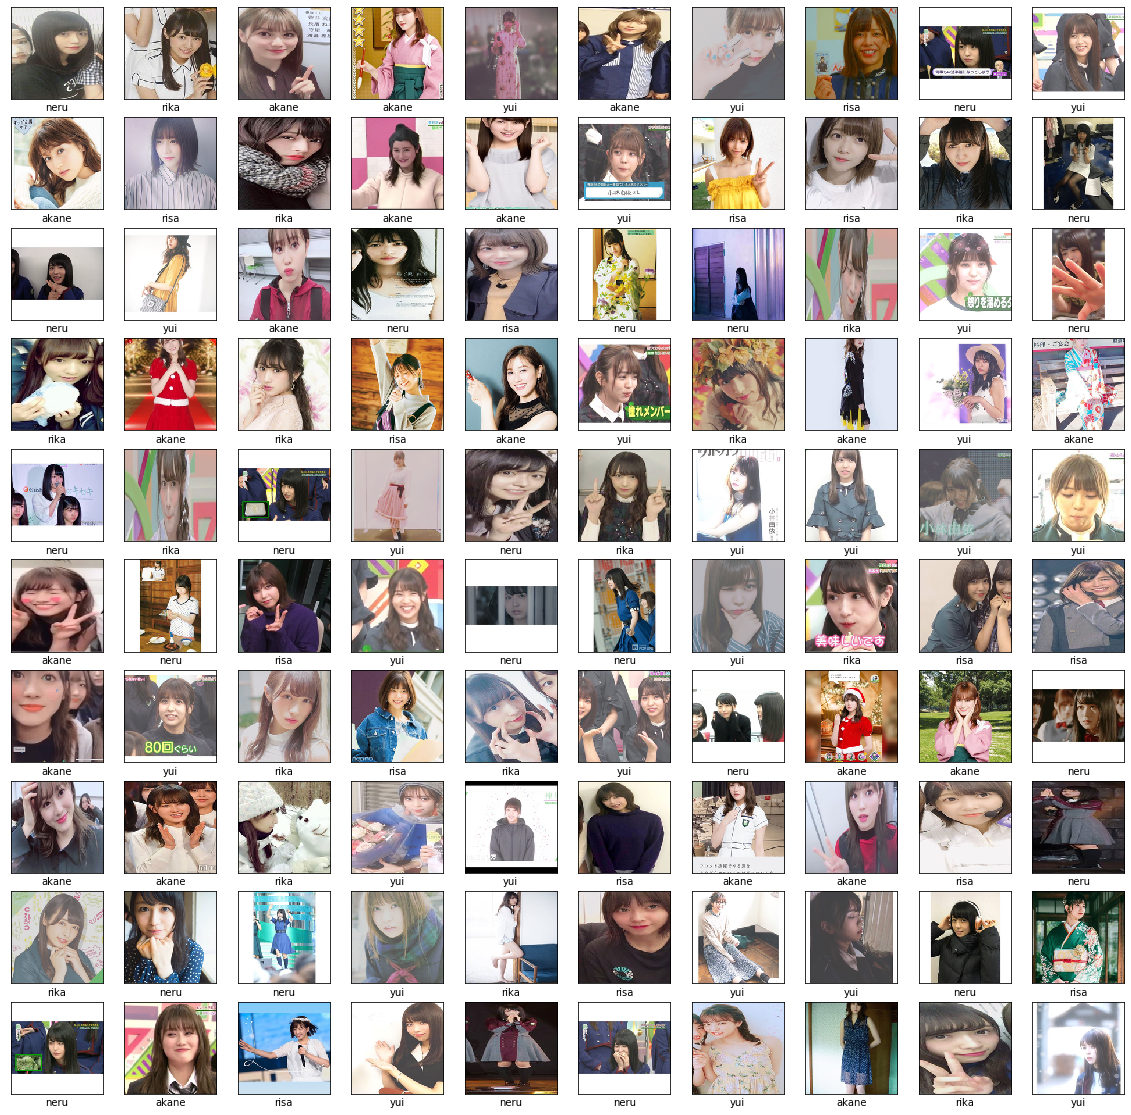

In [4]:
plot_sample_from_dataset(images, labels, rows=10, colums=10, width=20, height=20)

In [5]:
def extract_face(path_to_filename, detector, required_size=(160, 160), save_faces=True):

    
    image = Image.open(path_to_filename)
    image = image.convert('RGB')
    
    w, h = image.size
    
    pixels = asarray(image)
    results = detector.detect_faces(pixels)
    if len(results) != 0:
        x1, y1, width, height = results[0]['box']
    else:
        x1, y1, width, height = 0, 0, w, h

    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face = pixels[y1:y2, x1:x2]
    image = Image.fromarray(face)
    image = image.resize(required_size)
    if (save_faces):
        path = os.path.split(os.path.abspath(path_to_filename))[0]
        file_name = os.path.split(os.path.abspath(path_to_filename))[1]
        person_name = os.path.basename(os.path.normpath(Path(path)))
        project_folder = Path(path).parent.parent
        target_folder = str(project_folder) + '/faces_mini_dataset/' + person_name
        if not os.path.exists(target_folder):
            os.makedirs(target_folder)
        target_face_file_path = os.path.join(target_folder, file_name)
        image.save(target_face_file_path)
    
    face_array = asarray(image)
    return face_array

In [6]:
def extract_faces(directory):

    faces = list()    
    detector = MTCNN()
    
    for filename in tqdm(listdir(directory)):
        path = directory + filename
        try:
            face = extract_face(path, detector, save_faces=True)
        except Exception as e:
            continue
        faces.append(face)
        
    return faces

In [7]:
def generate_faces_from_images(directory):

    X, y = list(), list()    
    num = 1
    
    for subdir in listdir(directory):
        path = directory + subdir + '/'
        if not isdir(path):
            continue
        faces = extract_faces(path)
        labels = [subdir for _ in range(len(faces))]
        print('> %d) loaded %d examples for class: %s' % (num, len(faces), subdir))
        num += 1
        X.extend(faces)
        y.extend(labels)
        
    return asarray(X), asarray(y)

In [8]:
faces, labels = generate_faces_from_images(persons_dataset_path)

print(faces.shape, labels.shape)

100%|██████████| 100/100 [00:18<00:00,  5.42it/s]


> 1) loaded 100 examples for class: rika


100%|██████████| 103/103 [00:13<00:00,  7.40it/s]


> 2) loaded 102 examples for class: risa


100%|██████████| 108/108 [00:14<00:00,  7.38it/s]


> 3) loaded 107 examples for class: akane


100%|██████████| 115/115 [00:14<00:00,  7.95it/s]


> 4) loaded 114 examples for class: yui


100%|██████████| 115/115 [00:14<00:00,  8.21it/s]

> 5) loaded 115 examples for class: neru
(538, 160, 160, 3) (538,)


In [9]:
savez_compressed('face_dataset_numpy.npz', faces, labels)

In [10]:
faces_dataset_path = '/home/jovyan/Courses/Kaggle/aia-tp08-cnn-midterm/faces_mini_dataset/'
images, labels = load_rgb_data(faces_dataset_path, 160, shuffle=True)

Loading images...
['rika', 'risa', 'akane', 'yui', 'neru']
Loading rika
we will load [ 100 ] files from [ rika ] class ...
Loading risa
we will load [ 102 ] files from [ risa ] class ...
Loading akane
we will load [ 107 ] files from [ akane ] class ...
Loading yui
we will load [ 114 ] files from [ yui ] class ...
Loading neru
we will load [ 115 ] files from [ neru ] class ...
File loading completed.


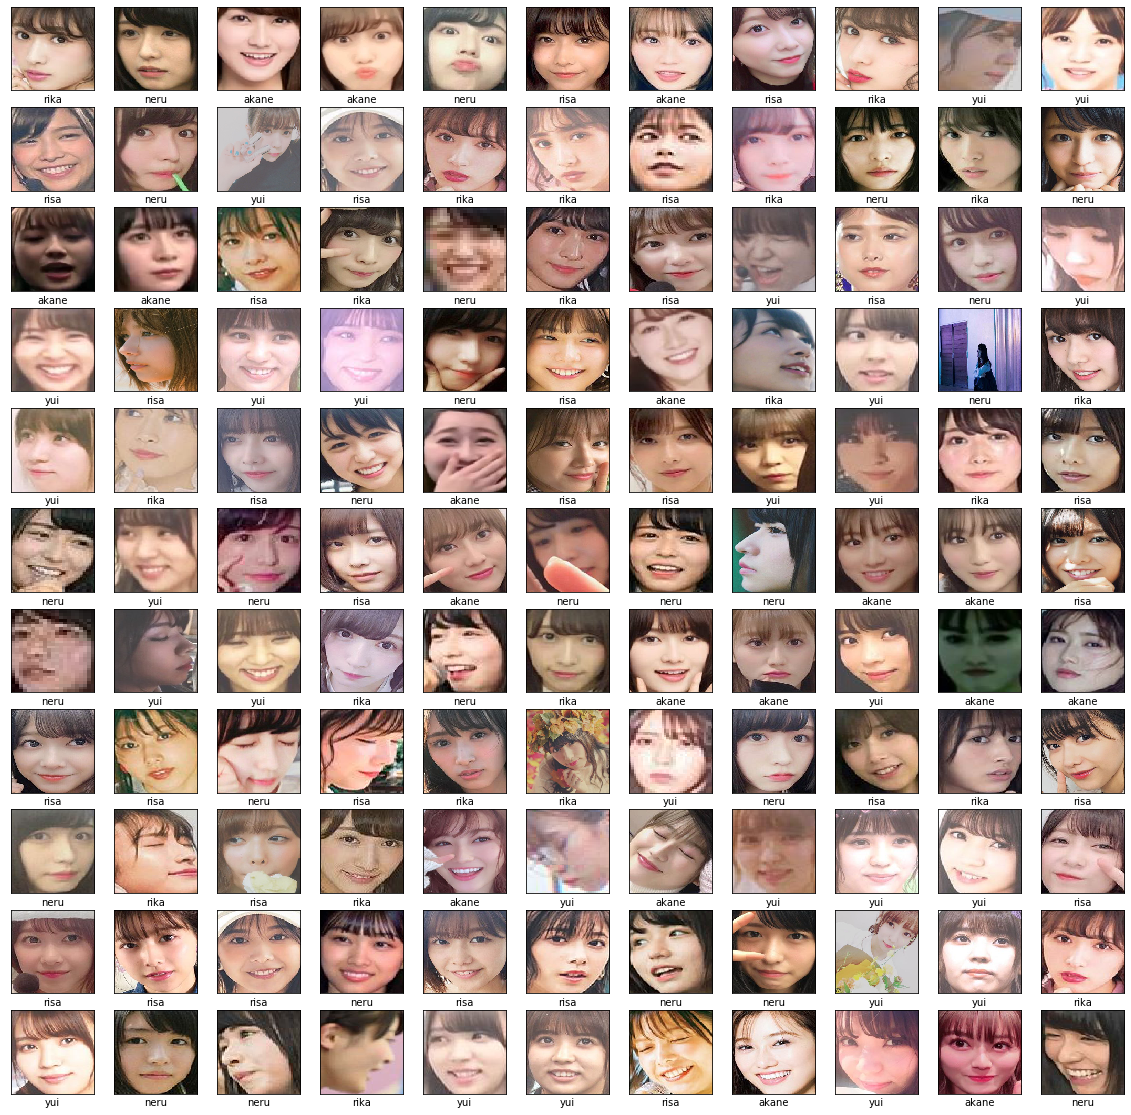

In [11]:
plot_sample_from_dataset(images, labels, rows=11, colums=11, width=20, height=20)

In [12]:
faces_dataset_numpy = 'face_dataset_numpy.npz'
from numpy import load
data = load(faces_dataset_numpy)
faces, labels2 = data['arr_0'], data['arr_1']

Label = neru
image shape:  (160, 160, 3)


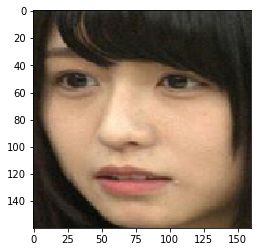

In [13]:
import matplotlib.pyplot as plt
display_image(images, labels, index=1)

Label = rika
image shape:  (160, 160, 3)


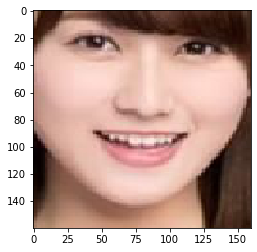

In [14]:
display_image(images, labels2, index=2)

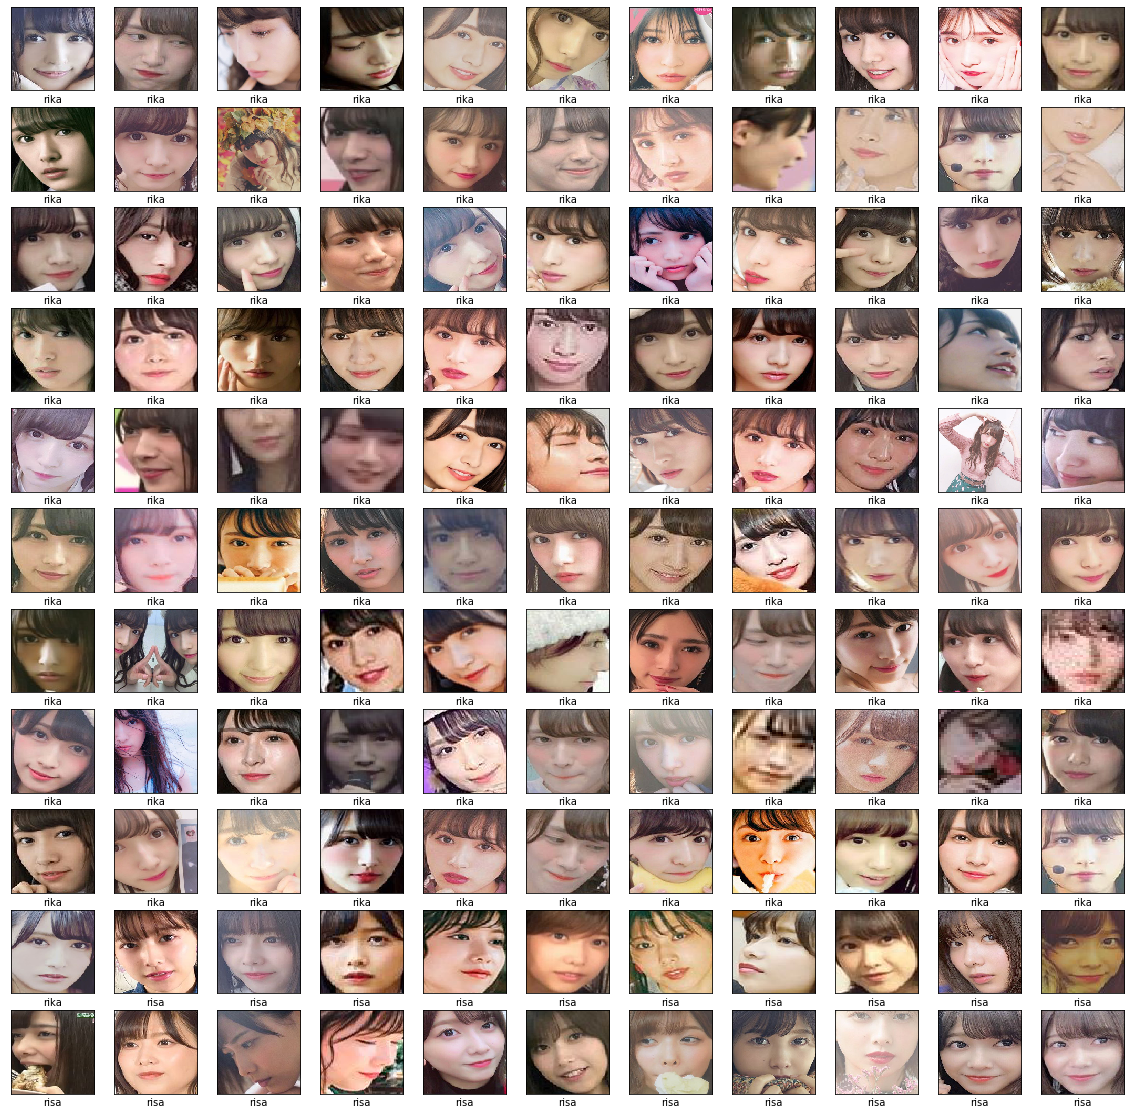

In [15]:
plot_sample_from_dataset(faces, labels2, rows=11, colums=11, width=20, height=20)

# Generate Embedding

In [16]:
def get_embedding(model, face_pixels):
    face_pixels = face_pixels.astype('float32')
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    samples = expand_dims(face_pixels, axis=0)
    yhat = model.predict(samples)
    return yhat[0]

In [17]:
faces_datasets_path = 'face_dataset_numpy.npz'
data = load(faces_datasets_path)
faces, labels = data['arr_0'], data['arr_1']
print('Loaded: ', faces.shape, labels.shape)

Loaded:  (538, 160, 160, 3) (538,)


In [18]:
model = tf.keras.models.load_model('facenet_keras.h5')

In [19]:
face_embeddings = list()
for face_pixels in faces:
    embedding = get_embedding(model, face_pixels)
    face_embeddings.append(embedding)
face_embeddings = asarray(face_embeddings)
print(face_embeddings.shape)

(538, 128)


In [20]:
savez_compressed('face_embeddings.npz', face_embeddings, labels)

# Facenet Face Recognition System

In [21]:
def classification(faces_embedding, labels):
    face_embedding = normalization2(faces_embedding)
    labels = lablization(labels)

    classifier = SVC(kernel='linear', probability=True)
#     classifier = MLPClassifier(solver='adam', activation='relu', random_state=23, hidden_layer_sizes=(100,))
#     classifier = KNeighborsClassifier(n_neighbors=30, p=1, weights='distance', metric='euclidean')
    classifier.fit(faces_embedding, labels)
    
    return classifier

def normalization(faces_embedding, face_to_predict_embedding):
    in_encoder = Normalizer(norm='l2')
    faces_embedding = in_encoder.transform(faces_embedding)
    face_to_predict_embedding = in_encoder.transform(face_to_predict_embedding)
    
    return faces_embedding, face_to_predict_embedding

def normalization2(faces_embedding):
    in_encoder = Normalizer(norm='l2')
    faces_embedding = in_encoder.transform(faces_embedding)
    
    return faces_embedding

def lablization(labels):
    out_encoder = LabelEncoder()
    out_encoder.fit(labels)
    labels = out_encoder.transform(labels)
    
    return labels

def predict2(face_to_predict_embedding, faces_embedding, labels, classifier):
    out_encoder = LabelEncoder()
    out_encoder.fit(labels)
    labels = out_encoder.transform(labels)
    
#     faces_embedding, face_to_predict_embedding = normalization(faces_embedding, face_to_predict_embedding)
#     face_emb = face_to_predict_embedding[0]
#     samples = expand_dims(face_emb, axis=0)

    yhat_class = classifier.predict(face_to_predict_embedding)
    print(yhat_class)
    yhat_prob = classifier.predict_proba(face_to_predict_embedding)
    print(yhat_prob)

    class_index = yhat_class[0]
    class_probability = yhat_prob[0, class_index] * 100
    
    predict_names = out_encoder.inverse_transform(yhat_class)[0]
    
    return predict_names, class_probability 

In [22]:
faces_embeddings_path = 'face_embeddings.npz'
data = load(faces_embeddings_path)
faces_embedding, labels = data['arr_0'], data['arr_1']

tick = time.time()
classifier = classification(faces_embedding, labels)
print('classifier time: ', time.time()-tick)

print('################ Loaded Embeddings ################')

classifier time:  0.09838318824768066
################ Loaded Embeddings ################


Label = testing_set/00C22FC0EA.png
image shape:  (160, 160, 3)
Time to extract image:  0.7171013355255127


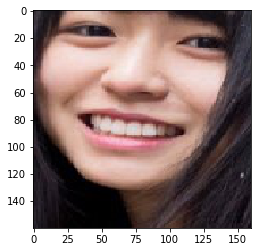

In [23]:
detector = MTCNN()

tick_begin = time.time()

image_to_predict = 'testing_set/00C22FC0EA.png'
# image_to_predict = 'testing_set/0B82408803.png'
# image_to_predict = 'testing_set/87A4969FED.png'
# image_to_predict = 'yui.png'
# image_to_predict = 'risa.png'

image = extract_face(image_to_predict, detector)

display_one_image(image, image_to_predict)
print('Time to extract image: ', time.time()-tick_begin)

tick = time.time()

In [24]:
face_to_predict_embedding = get_embedding(model, image)
face_to_predict_embedding = face_to_predict_embedding.reshape(1, -1)
face_to_predict_embedding

array([[-6.8825734e-01, -1.6907407e+00,  8.0904174e-01,  5.2601981e-01,
        -3.7492794e-01, -1.7560952e+00,  1.3890836e-01, -1.3762226e+00,
        -1.6071354e+00, -9.4853914e-01,  2.4211517e-01, -1.5222721e+00,
        -1.0949211e+00, -1.3731316e-01, -1.4730945e-02, -1.8083395e-01,
        -2.1580029e-01,  8.1506515e-01, -1.3648965e+00,  3.9942345e-01,
        -2.8616005e-01, -1.0201561e+00,  5.3775090e-01, -2.0768054e+00,
         9.5672959e-01, -5.9252685e-01, -1.0908555e-01,  2.6374245e-01,
        -3.1814587e-01, -6.5332524e-02,  5.7828758e-02,  3.4480610e-01,
         6.5281326e-01, -6.9511151e-01, -1.4812686e-06, -6.7591298e-01,
         9.4365573e-01, -3.0674440e-01,  6.5957147e-01, -7.2778285e-01,
         3.9859515e-01, -4.6086600e-01, -9.1924298e-01,  2.5386751e-01,
         8.6367697e-01, -3.8250786e-01, -6.5370917e-02,  1.2971034e+00,
        -1.0606227e+00,  7.8207707e-01, -5.5654401e-01,  6.5344147e-02,
         3.5351750e-01, -1.4462951e-01,  6.9273758e-01,  5.37194

In [25]:
faces_embedding
faces_embedding.shape

(538, 128)

In [26]:
image = extract_face(image_to_predict, detector)
face_to_predict_embedding = get_embedding(model, image)
face_to_predict_embedding = face_to_predict_embedding.reshape(1, -1)
classifier.predict(face_to_predict_embedding)

array([4])

In [27]:
tick_begin = time.time()

predict_name, class_probability = predict2(face_to_predict_embedding, faces_embedding, labels, classifier)

unknown_name = 'Unknown'

if (class_probability >= 50):
    print('Predicted: %s (%.3f)' % (predict_name, class_probability))
    unknown_name = ' '

else:
    unknown_name = 'Unknown'
    print('Predicted %s (%.3f)' % (unknown_name, class_probability))
    print('Closed Prediction: ', predict_name)
    
face_expected_name = re.findall('testing_set/(\w+).png', image_to_predict)
print(face_expected_name)

print('Total Time to predict: ', time.time()-tick_begin)

[4]
[[0.02160341 0.32566041 0.04412251 0.1580953  0.45051837]]
Predicted Unknown (45.052)
Closed Prediction:  yui
['00C22FC0EA']
Total Time to predict:  0.002641439437866211


In [28]:
predict_name, class_probability

('yui', 45.05183709092048)

In [29]:
submission = pd.read_csv("sample_submission.csv")

In [30]:
submission

id  class
0    61B0E5C347      0
1    129970B6FE      0
2    9B563E666C      0
3    730049E065      0
4    36063E5BF3      0
..          ...    ...
433  B7C62F06E0      0
434  88DE9A0DA4      0
435  D2C2A30BBD      0
436  FCED87FC66      0
437  FAC04BFD86      0

[438 rows x 2 columns]

In [31]:
data_path = "testing_set/"

x_data_list = []
y_data_list = []
for roots, dirs, files in os.walk(data_path):
    for each in files:
        if each.find('checkpoint') == -1:
            x_data_list.append(os.path.join(roots.split("/")[-1], each))
            y_data_list.append(roots.split("/")[-1])

In [32]:
y_data_list = []
for i in tqdm(x_data_list):
    
    image_to_predict = 'testing_set/' + i
    image = extract_face(image_to_predict, detector)
    face_to_predict_embedding = get_embedding(model, image)
    face_to_predict_embedding = face_to_predict_embedding.reshape(1, -1)
#     predict_name, class_probability = predict2(face_to_predict_embedding, faces_embedding, labels, classifier)
    predict_name = list(classifier.predict(face_to_predict_embedding))
    
    y_data_list += predict_name

100%|██████████| 438/438 [01:43<00:00,  4.22it/s]


In [33]:
for i in range(len(x_data_list)):
    x_data_list[i] = str(x_data_list[i].split('.')[0])

In [34]:
submission = pd.DataFrame({'id':x_data_list,'class':y_data_list})

In [35]:
submission

id  class
0    DA029182F0      1
1    798013C730      4
2    B5844A85AD      0
3    C18C7E50D2      3
4    D16FAB0C67      2
..          ...    ...
433  ABA2AB52B9      3
434  5D24B9F7C4      4
435  A044294D03      2
436  56A4659066      1
437  416D521441      3

[438 rows x 2 columns]

In [36]:
submission['class'] = np.where(submission['class'] == 0, '5', submission['class'])
submission['class'] = np.where(submission['class'] == '2', '0', submission['class'])
submission['class'] = np.where(submission['class'] == '4', '2', submission['class'])
submission['class'] = np.where(submission['class'] == '1', '4', submission['class'])
submission['class'] = np.where(submission['class'] == '3', '1', submission['class'])
submission['class'] = np.where(submission['class'] == '5', '3', submission['class'])

In [37]:
submission

id class
0    DA029182F0     4
1    798013C730     2
2    B5844A85AD     3
3    C18C7E50D2     1
4    D16FAB0C67     0
..          ...   ...
433  ABA2AB52B9     1
434  5D24B9F7C4     2
435  A044294D03     0
436  56A4659066     4
437  416D521441     1

[438 rows x 2 columns]

In [38]:
submission.to_csv('210205 midterm-cnn-facenet.csv', index = 0)